<a href="https://colab.research.google.com/github/abdallaho98/AutoSpeech/blob/master/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip3 install ktrain

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [3]:
import ktrain
from ktrain import text

In [4]:
import pandas as pd
filepath = 'legalts.txt'
df = pd.DataFrame(columns=('type', 'content'))
with open(filepath) as fp:
   line = fp.readline()
   cnt = 0
   while line:
       x = line.strip().split("  ")
       df.loc[cnt] = [int(x[1]) , x[0]]
       line = fp.readline()
       cnt += 1
df['type'] = df['type'].apply(lambda x: 'right' if x == 1 else 'permit' if x == 2 else 'obligation' if x == 3 else 'prohibition' if x == 4 else 'other')
df.columns = ['label', 'text']
df = pd.concat([df, df.label.astype('str').str.get_dummies()], axis=1, sort=False)
df = df[['text', 'right', 'permit','obligation' ,'prohibition' , 'other']]
df.head()

,text,right,permit,obligation,prohibition,other
0,ليس للشركاء في مال شائع أن يطلبوا قسمته إذا تب...,0,0,0,1,0
1,إذا وقع تحريف في نص السفتجة فالأشخاص الموقعون ...,0,0,0,0,1
2,يجوز الحجز على الأجر أو المرتب بقيمة النفقة ال...,0,1,0,0,0
3,يعين القاضي طبقا لأحكام قانون الأسرة، مقدما من...,0,0,1,0,0
4,يجوز للعموم المعارضة في أي تصحيح قضائي أو إدار...,0,1,0,0,0


In [56]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(df, 
                                                                   'text', # name of column containing review text
                                                                   label_columns=['right', 'permit','obligation' ,'prohibition' , 'other'],
                                                                   maxlen=575, 
                                                                   max_features=100000,
                                                                   preprocess_mode='standard',
                                                                   val_pct=0.1,
                                                                   ngram_range=3)


language: ar
Word Counts: 6721
Nrows: 931
931 train sequences
train sequence lengths:
	mean : 27
	95percentile : 49
	99percentile : 61
Adding 3-gram features
max_features changed to 138759 with addition of ngrams
Average train sequence length with ngrams: 78
train (w/ngrams) sequence lengths:
	mean : 78
	95percentile : 144
	99percentile : 181
x_train shape: (931,575)
y_train shape: (931, 5)
Is Multi-Label? False
104 test sequences
test sequence lengths:
	mean : 22
	95percentile : 37
	99percentile : 45
Average test sequence length with ngrams: 34
test (w/ngrams) sequence lengths:
	mean : 35
	95percentile : 70
	99percentile : 93
x_test shape: (104,575)
y_test shape: (104, 5)


In [118]:
model = text.text_classifier('nbsvm', (x_train, y_train) , preproc=preproc)
learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=32)

Is Multi-Label? False
compiling word ID features...
maxlen is 575
building document-term matrix... this may take a few moments...
rows: 1-931
computing log-count ratios...
done.


simulating training for different learning rates... this may take a few moments...
Train on 931 samples
Epoch 1/5


/usr/local/lib/python3.6/dist-packages/ktrain/core.py:547: UserWarning: max_epochs is being set to 5 since steps per epoch is small. If you wish to estimate LR using more epochs, set max_epochs manually.
  'If you wish to estimate LR using more epochs, set max_epochs manually.')


931/931 [==============================] - 0s 520us/sample - loss: 1.6206 - accuracy: 0.2417
Epoch 2/5
931/931 [==============================] - 0s 164us/sample - loss: 1.6171 - accuracy: 0.2739
Epoch 3/5
931/931 [==============================] - 0s 174us/sample - loss: 1.4911 - accuracy: 0.7723
Epoch 4/5
931/931 [==============================] - 0s 164us/sample - loss: 0.4316 - accuracy: 0.9742
Epoch 5/5
931/931 [==============================] - 0s 172us/sample - loss: 0.0763 - accuracy: 0.9850


done.
Visually inspect loss plot and select learning rate associated with falling loss


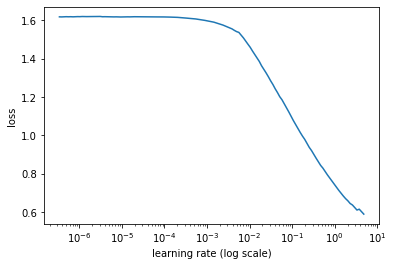

In [119]:
learner.lr_find(show_plot=True)

In [123]:
learner.autofit(5e-3, 1)



begin training using triangular learning rate policy with max lr of 0.005...
Train on 931 samples, validate on 104 samples
931/931 [==============================] - 0s 183us/sample - loss: 0.0538 - accuracy: 0.9946 - val_loss: 1.0542 - val_accuracy: 0.7115


In [98]:
learner.view_top_losses(n=1, preproc=preproc)

----------
id:46 | loss:6.97 | true:permit | pred:right)

معدلة يجوز للزوجة دون موافقة الزوج أن تخالع نفسها بمقابل مالی إذا لم يتفق الزوجان على المقابل المالي للخلع، يحكم القاضي بما لا يتجاوز قيمة صداق المثل وقت صدور الحكم 3


In [99]:
p = ktrain.get_predictor(learner.model, preproc)

In [109]:
p.predict("لا يجوز أن يكون تأويل العبارات الغامضة في عقود الاذعان ضارا بمصلحة الطرف المذعن")

'prohibition'

In [111]:
p.predict("يمنع إبطال العقد إذا لم يتمسك به صاحبه خلال خمس )5( سنوات.")

'permit'

In [112]:
p.predict("يجوز أن يؤمر بالنفاذ المعجل بالنسبة لهذا الإجرا")

'permit'

In [113]:
p.predict("يجوز تخفيض العقوبة المنصوص عليها قانونا بالنسبة للشخص الطبيعي الذي قضي بإدانته وتقررت إفادته بظروف مخففة")

'permit'